In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split


In [2]:
df = pd.read_csv("/content/sample_data/feature_engineered_data.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.head()


,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,rolling_std_4,Year,Month,Week,Quarter,pre_holiday,Total_Markdown,Avg_Markdown,Type_B,Size_Log
0,1,1,2010-03-05,21827.90,0,46.50,2.625,0.0,0.0,0.0,...,12832.106391,2010,3,9,1,0.0,0.0,0.0,False,11.927126
1,1,1,2010-03-12,21043.39,0,57.79,2.667,0.0,0.0,0.0,...,13554.047185,2010,3,10,1,0.0,0.0,0.0,False,11.927126
2,1,1,2010-03-19,22136.64,0,54.58,2.720,0.0,0.0,0.0,...,10467.484020,2010,3,11,1,0.0,0.0,0.0,False,11.927126
3,1,1,2010-03-26,26229.21,0,51.45,2.732,0.0,0.0,0.0,...,1222.784968,2010,3,12,1,0.0,0.0,0.0,False,11.927126
4,1,1,2010-04-02,57258.43,0,62.27,2.719,0.0,0.0,0.0,...,2325.929203,2010,4,13,2,0.0,0.0,0.0,False,11.927126


In [3]:
split_date = df['Date'].quantile(0.8)

train = df[df['Date'] <= split_date]
test  = df[df['Date'] > split_date]


In [4]:
X_train = train.drop(['Weekly_Sales','Date'], axis=1)
y_train = train['Weekly_Sales']

X_test = test.drop(['Weekly_Sales','Date'], axis=1)
y_test = test['Weekly_Sales']


In [5]:
baseline_preds = test['lag_1']
baseline_mae = mean_absolute_error(y_test, baseline_preds)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_preds))

print("Baseline MAE:", baseline_mae)
print("Baseline RMSE:", baseline_rmse)


Baseline MAE: 1699.4814182423595
Baseline RMSE: 3624.776425130806


In [6]:
from sklearn.ensemble import RandomForestRegressor


In [8]:
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)


RandomForestRegressor(max_depth=15, min_samples_split=5, n_estimators=200,
                      n_jobs=-1, random_state=42)

In [9]:
rf_preds = rf.predict(X_test)
rf_mae = mean_absolute_error(y_test, rf_preds)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))

print("Random Forest MAE:", rf_mae)
print("Random Forest RMSE:", rf_rmse)


Random Forest MAE: 1562.778176021206
Random Forest RMSE: 3171.587819289231


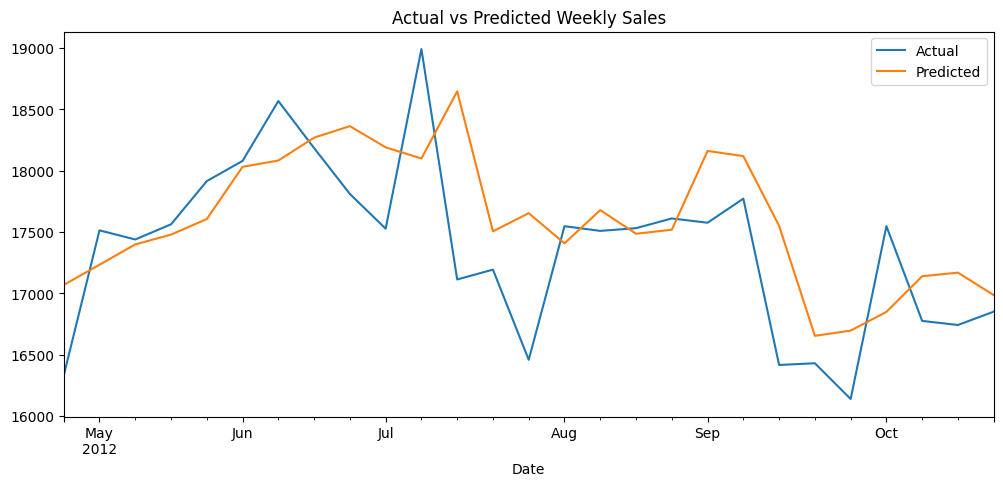

In [12]:
import matplotlib.pyplot as plt

comparison = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': rf_preds
}, index=test['Date'])
comparison.resample('W').mean().plot(figsize=(12,5))
plt.title("Actual vs Predicted Weekly Sales")
plt.show()

In [13]:
from prophet import Prophet
ts = df.groupby('Date')['Weekly_Sales'].sum().reset_index()
ts.columns = ['ds','y']


In [14]:
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)
model.fit(ts)


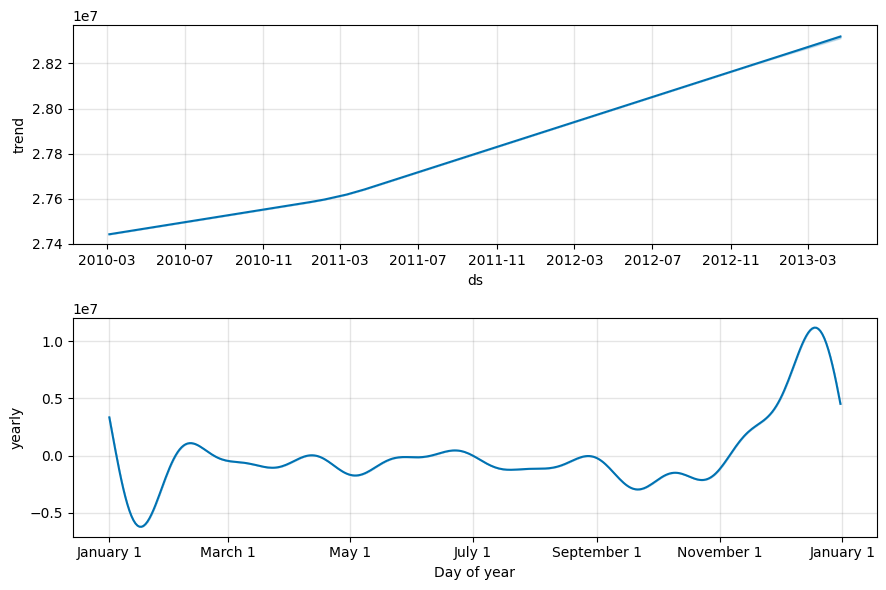

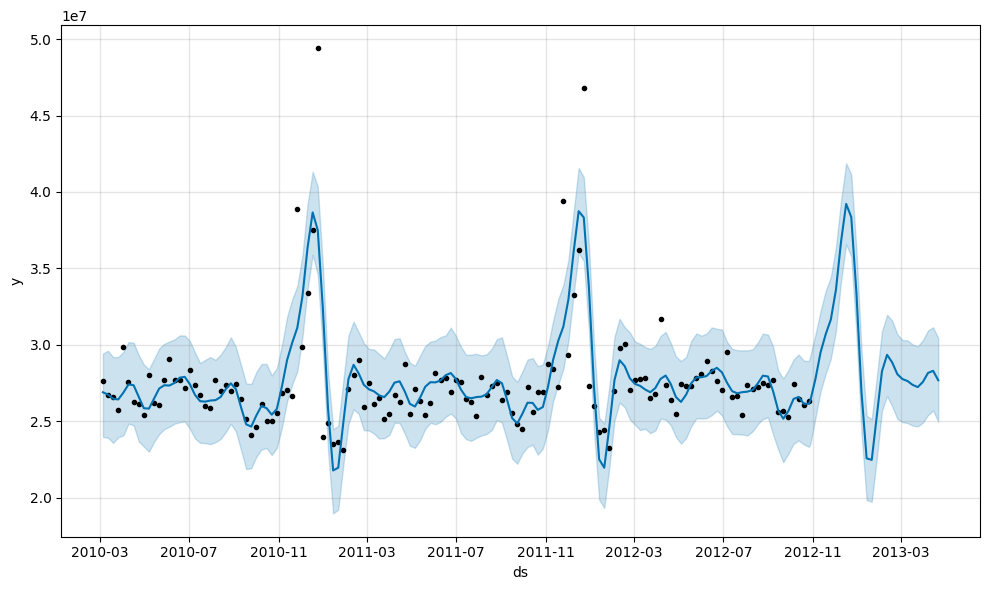

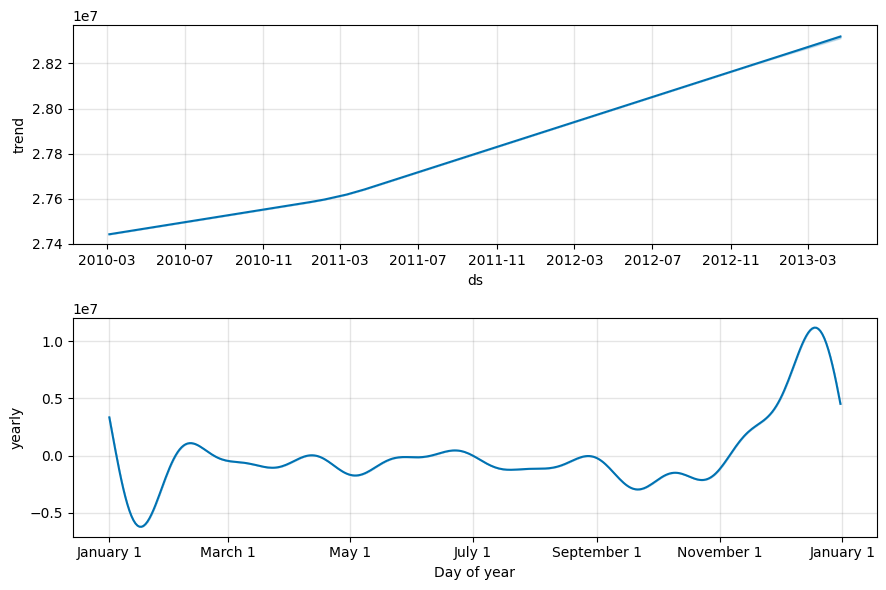

In [15]:
future = model.make_future_dataframe(periods=26, freq='W')
forecast = model.predict(future)
model.plot(forecast)
model.plot_components(forecast)
